### Problem: 
Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

### Goal:
Predicting the probabilities for different click_id's in the test set.**

For each click_id in the test set, we must predict a probability for the target is_attributed variable. The file should contain a header and have the following format:
* click_id,is_attributed
* 1,0.003
* 2,0.001
* 3,0.000
* etc.

### Dataset Description
Each row of the training data contains a click record, with the following features.

- **ip**: ip address of click.
- **app**: app id for marketing.
- **device**: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
- **os**: os version id of user mobile phone
- **channel**: channel id of mobile ad publisher
- **click_time**: timestamp of click (UTC)
- **attributed_time**: if user download the app for after clicking an ad, this is the time of the app download
- **is_attributed**: the target that is to be predicted, indicating the app was downloaded
    Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:
- **click_id**: reference for making predictions
- **is_attributed**: not included

### Evaluation:
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

### TLDR; Summary
- Total train samples are 184,903,890.
- Total test samples are 18,790,469.
- Total test supplement samples are 57,537,505. 
- Percentage of positive data: 0.2%
- Used last 10M rows to down sample the data since the dataset is very big.
- Used Kaggle kernel for training and generating the output for this problem 
- Used XGBoost for training and testing purposes

### Leaderboard Score:
- **Public score**: 0.95613
- **Private score**: 0.95558

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test_supplement.csv', 'train_sample.csv', 'train.csv', 'sample_submission.csv', 'test.csv']


In [6]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
import gc
import time
from datetime import datetime
%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(12,5))

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

### Train dataset

In [7]:
train_path = "../input/" + 'train.csv'
train_df = pd.read_csv(train_path, nrows = 10000)
train_df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


### Test dataset

In [8]:
test_path = "../input/" + 'test.csv'
test_df = pd.read_csv(test_path, nrows = 10000)
test_df.head()

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


### Test supplement dataset

In [9]:
test_sup_path = "../input/" + 'test_supplement.csv'
test_sup_df = pd.read_csv(test_sup_path, nrows = 10000)
test_sup_df.head()

,click_id,ip,app,device,os,channel,click_time
0,0,43570,3,1,18,379,2017-11-09 14:23:39
1,1,80528,3,1,13,379,2017-11-09 14:23:51
2,2,32323,3,1,13,379,2017-11-09 14:25:57
3,3,42887,3,1,17,379,2017-11-09 14:26:03
4,4,119289,58,1,30,120,2017-11-09 14:26:41


In [10]:
train_df.dtypes

ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
click_time         object
attributed_time    object
is_attributed       int64
dtype: object

In [11]:
train_cols = ['ip','app','device','os','channel','click_time','is_attributed']
test_cols = ['ip','app','device','os','channel','click_time','click_id']

# By default, pandas sets the dtype of integers to int64. In many cases, 
# this datatype takes up extra memory which is just not required.
# For example: int64 datatype takes in 8 bytes and can represent humongous integers, 
# from -9223372036854775808 to 9223372036854775807. Hence, memory reduction by changing 
# the datatypes is very helpful.

dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'click_id'      : 'uint32',
        'is_attributed' : 'uint8'
        }

In [12]:
# Reading the last 10M rows for down sampling the data
train_df = pd.read_csv( '../input/' + "train.csv", skiprows=range(1,123903891), nrows=10000000, usecols=train_cols, dtype=dtypes)
test_sup_df = pd.read_csv('../input/' + "test_supplement.csv", usecols=test_cols, dtype=dtypes)

In [13]:
# Feature extraction using click_time column in the datasets
def feature_extraction(df):
    df['date'] = pd.to_datetime(df['click_time'])
    df['dayOfWeek'] = df['date'].dt.dayofweek.astype('uint16')
    df['dayOfYear'] = df['date'].dt.dayofyear.astype('uint16')
    df['hour'] = df['date'].dt.hour.astype('uint8')
    df['min'] = df['date'].dt.minute.astype('uint8')
    df['sec'] = df['date'].dt.second.astype('uint8')
    df.drop(['date','click_time'], axis= 1, inplace=True)
    return df

In [14]:
# drop the target values from train dataset 
y = train_df['is_attributed']
train_df.drop(['is_attributed'], axis=1, inplace=True)

In [15]:
# drop the click_time from the test data
test_sup_df.drop(['click_id'], axis=1, inplace=True)
gc.collect()

166

In [16]:
# Merging the supplement data with test data
rows_train = train_df.shape[0]
merge_df = pd.concat([train_df, test_sup_df])
merge_df.head()

,ip,app,device,os,channel,click_time
0,210014,9,1,13,334,2017-11-08 16:41:52
1,2076,3,1,32,211,2017-11-08 16:41:52
2,296481,9,1,19,232,2017-11-08 16:41:52
3,33473,15,1,13,245,2017-11-08 16:41:52
4,115014,3,1,13,137,2017-11-08 16:41:52


In [17]:
print('Length of combine dataset: ', len(merge_df))

Length of combine dataset:  67537505


In [18]:
del train_df, test_sup_df
gc.collect()

11

In [19]:
# Group by ip to count the number of clicks
ip_groups = merge_df.groupby(['ip'])['channel'].count().reset_index(name = 'clicks_by_ip')
print(ip_groups)

            ip  clicks_by_ip
0            0             2
1            1            67
2            2             6
3            3           291
4            4            39
5            5            99
6            6           867
7            7             1
8            8             2
9            9          1577
10          10           598
11          11             9
12          12            30
13          13            27
14          14             4
15          15             1
16          16            13
17          17             1
18          18            18
19          19           415
20          20          1943
21          21            38
22          22            15
23          23             4
24          24             4
25          25           608
26          26            21
27          27          1019
28          28             3
29          29            93
...        ...           ...
165535  364698             1
165536  364702             3
165537  364705

In [20]:
merge_df = pd.merge(merge_df, ip_groups, on='ip', how='left', sort=False)
print(merge_df.head())

       ip  app  device     ...       channel           click_time clicks_by_ip
0  210014    9       1     ...           334  2017-11-08 16:41:52          110
1    2076    3       1     ...           211  2017-11-08 16:41:52        19072
2  296481    9       1     ...           232  2017-11-08 16:41:52          101
3   33473   15       1     ...           245  2017-11-08 16:41:52         2972
4  115014    3       1     ...           137  2017-11-08 16:41:52         2219

[5 rows x 7 columns]


In [21]:
merge_df['clicks_by_ip'] = merge_df['clicks_by_ip'].astype('uint16')
merge_df.drop('ip', axis=1, inplace=True)

In [22]:
train_df = merge_df[:rows_train]
test_df = merge_df[rows_train:]

In [23]:
del test_df,merge_df
gc.collect()

65

In [24]:
train_df = feature_extraction(train_df)
gc.collect()

98

In [25]:
train_df.head()

,app,device,os,channel,clicks_by_ip,dayOfWeek,dayOfYear,hour,min,sec
0,9,1,13,334,110,2,312,16,41,52
1,3,1,32,211,19072,2,312,16,41,52
2,9,1,19,232,101,2,312,16,41,52
3,15,1,13,245,2972,2,312,16,41,52
4,3,1,13,137,2219,2,312,16,41,52


In [26]:
# Set the params for xgboost model
params = {'eta': 0.3,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,  
          'max_depth': 0, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':0,
          'alpha':4,
          'objective': 'binary:logistic', 
          'scale_pos_weight':9,
          'eval_metric': 'auc', 
          'nthread':8,
          'random_state': 99, 
          'silent': True}

In [27]:
# Change this for validation with 10% from train dataset
is_valid = False

In [28]:
# Used XGBoost algorithm for model preparation for the following reasons:
# XGBoost has high predictive power and is almost 10 times faster than the other gradient boosting techniques.
# It also includes a variety of regularization which reduces overfitting and improves overall performance.
# Found the above parameters giving the best results

if (is_valid == True):
    # Get 10% of train dataset to use as validation
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.1, stratify=y, random_state=99)
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_test, y_test)
    del X_train, X_test, y_train, y_test 
    gc.collect()
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds = 25, verbose_eval=5)
    del dvalid
else:
    dtrain = xgb.DMatrix(train_df, y)
    del train_df, y
    gc.collect()
    watchlist = [(dtrain, 'train')]
    model = xgb.train(params, dtrain, 30, watchlist, maximize=True, verbose_eval=1)

del dtrain
gc.collect()

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	train-auc:0.907637
[1]	train-auc:0.934206
[2]	train-auc:0.952543
[3]	train-auc:0.952419
[4]	train-auc:0.957152
[5]	train-auc:0.960175
[6]	train-auc:0.96254
[7]	train-auc:0.961796
[8]	train-auc:0.963922
[9]	train-auc:0.965564
[10]	train-auc:0.966491
[11]	train-auc:0.968804
[12]	train-auc:0.9685
[13]	train-auc:0.970636
[14]	train-auc:0.97392
[15]	train-auc:0.976255
[16]	train-auc:0.978329
[17]	train-auc:0.981394
[18]	train-auc:0.983921
[19]	train-auc:0.986226
[20]	train-auc:0.98836
[21]	train-auc:0.990724
[22]	train-auc:0.99339
[23]	train-auc:0.994927
[24]	train-auc:0.995904
[25]	train-auc:0.996725
[26]	train-auc:0.997272
[27]	train-auc:0.997623
[28]	train-auc:0.998034
[29]	train-auc:0.998419


21

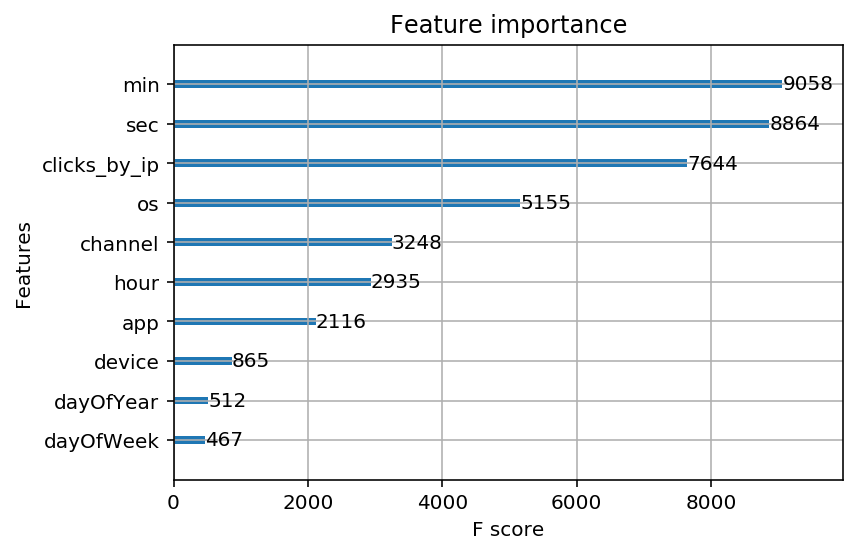

In [30]:
# Plot the feature importances from xgboost
plot_importance(model)
plt.gcf().savefig('xgb_feature_importance.png')

In [31]:
# Load the test dataset for prediction
test_cols  = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'click_id']
test_df = pd.read_csv('../input/' +"test.csv", usecols=test_cols, dtype=dtypes)
test_df = pd.merge(test_df, ip_groups, on='ip', how='left', sort=False)
del ip_groups
gc.collect()

3112

In [32]:
test_df.head()

,click_id,ip,app,device,os,channel,click_time,clicks_by_ip
0,0,5744,9,1,3,107,2017-11-10 04:00:00,403
1,1,119901,9,1,3,466,2017-11-10 04:00:00,7414
2,2,72287,21,1,19,128,2017-11-10 04:00:00,5888
3,3,78477,15,1,13,111,2017-11-10 04:00:00,3816
4,4,123080,12,1,13,328,2017-11-10 04:00:00,683


In [33]:
# Creating a dataframe for submission
submission_df = pd.DataFrame()
submission_df['click_id'] = test_df['click_id'].astype('int')

test_df['clicks_by_ip'] = test_df['clicks_by_ip'].astype('uint16')
test_df = feature_extraction(test_df)
test_df.drop(['click_id', 'ip'], axis=1, inplace=True)
dtest = xgb.DMatrix(test_df)
del test_df
gc.collect()

166

In [34]:
submission_df.head()

,click_id
0,0
1,1
2,2
3,3
4,4


In [35]:
# Get predictions from the best iteration with model.best_ntree_limit.
submission_df['is_attributed'] = model.predict(dtest, ntree_limit=model.best_ntree_limit)
submission_df.to_csv('xgb_submission.csv', float_format='%.8f', index=False)